In [1]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import util_functions as uf
import altair as alt
import json
import requests
from datetime import date
from geopy.distance import great_circle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

In [2]:
def query(con):
    # queries bikeshare db
    return pd.read_sql("""/* CaBi Station Coordinates*/
                            WITH 
                            station_coords AS (SELECT short_name, 
                                            lat, 
                                            lon				      
                                            FROM cabi_stations)


                            SELECT
                            start_date::date as date,
                            CASE WHEN left(bike_number, 1) in ('?', 'w', 'W', 'Z') 
                                THEN 'CaBi Classic' 
                                ELSE 'CaBi Plus' END as "CaBi Bike Type",
                            start_station,
                            start_coords.lat as start_lat,
                            start_coords.lon as start_lon,
                            end_station,
                            end_coords.lat as end_lat,
                            end_coords.lon as end_lon,
                            end_date - start_date as total_trip_dur
                            FROM cabi_trips as cabi_trips
                            /* JOIN on start station lat, lon */
                            LEFT JOIN station_coords as start_coords
                            ON cabi_trips.start_station = start_coords.short_name
                            /* JOIN on end station lat, lon */
                            LEFT JOIN station_coords as end_coords
                            ON cabi_trips.end_station = end_coords.short_name

                            WHERE start_date::date >= '2018-09-05'
                            AND end_date > start_date
                            AND member_type = 'Member'
                            ;
                        """, con=con)

In [43]:
# Generating Data
conn, cur = uf.local_connect()
# Return Dataframe of Percent of Trips by ANC
df = query(con=conn)
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
# Convert timedelta to float of hours and minutes
df['Trip Duration (hours)'] = df['total_trip_dur'] / np.timedelta64(1, 'h')
df['Trip Duration (minutes)'] = df['total_trip_dur'] / np.timedelta64(1, 'm')
# Calculate distance between coordinates
df['distance'] = df.apply(lambda x: great_circle((x['start_lat'], x['start_lon']), 
                                                           (x['end_lat'], x['end_lon'])).miles, axis = 1)
# MPH
df['mph'] = df['distance'] / df['Trip Duration (hours)'] 
# Average Distance by CaBi/CaBi Plus    
print(df[df['distance'] > 0].groupby('CaBi Bike Type')['distance'].mean())

# Average MPH by CaBi/CaBi Plus
print(df[df['distance'] > 0].groupby('CaBi Bike Type')['mph'].mean())

CaBi Bike Type
CaBi Classic    1.115792
CaBi Plus       1.323669
Name: distance, dtype: float64
CaBi Bike Type
CaBi Classic    5.966137
CaBi Plus       6.615992
Name: mph, dtype: float64


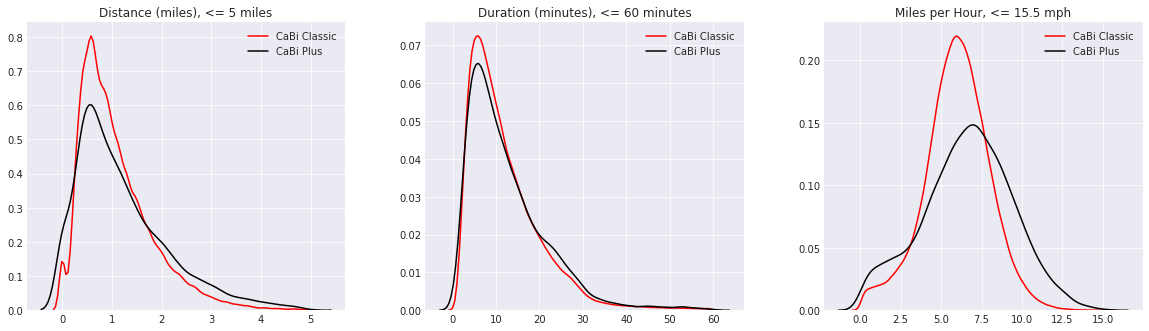

In [85]:
fig, axes = plt.subplots(figsize=(20,5), ncols=3, nrows=1)

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .25    # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots

plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)


sns.set_style("darkgrid")

# The amount of space above titles
#y_title_margin = 1.0

#plt.suptitle("Distribution of CaBi Member Trips", y = 1.09, fontsize=20)

axes[0].set_title("Distance (miles), <= 5 miles", y = y_title_margin)
axes[1].set_title("Duration (minutes), <= 60 minutes", y = y_title_margin)
axes[2].set_title("Miles per Hour, <= 15.5 mph", y = y_title_margin)

# Distance
dist_df = df[df['distance'] <= 5]
sns.distplot(dist_df[dist_df['CaBi Bike Type'] == 'CaBi Classic']['distance'],  
             ax = axes[0],
             axlabel = False,
             hist=False,             
             label="CaBi Classic", 
             color='red')  

sns.distplot(dist_df[dist_df['CaBi Bike Type'] == 'CaBi Plus']['distance'], 
             ax = axes[0],
             axlabel = False,
             hist=False,
             label="CaBi Plus", 
             color='black')

# Duration
dur_df = df[df['Trip Duration (minutes)'] <= 60]

sns.distplot(dur_df[dur_df['CaBi Bike Type'] == 'CaBi Classic']['Trip Duration (minutes)'],  
             ax = axes[1],
             axlabel = False,
             hist=False, 
             label="CaBi Classic", 
             color='red')  
sns.distplot(dur_df[dur_df['CaBi Bike Type'] == 'CaBi Plus']['Trip Duration (minutes)'], 
             ax = axes[1],
             axlabel = False,
             hist=False, 
             label="CaBi Plus", 
             color='black')

#MPH

mph_df = df[(df['mph'] > 0) & (df['mph'] < 15.5)]

sns.distplot(mph_df[mph_df['CaBi Bike Type'] == 'CaBi Classic']['mph'],  
             ax = axes[2],
             axlabel = False,
             hist=False, 
             label="CaBi Classic", 
             color='red')  
sns.distplot(mph_df[mph_df['CaBi Bike Type'] == 'CaBi Plus']['mph'], 
             ax = axes[2],
             axlabel = False,
             hist=False, 
             label="CaBi Plus", 
             color='black')
plt.savefig('../plots_output/cabi_distribution.png')